In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_lowLR",
    "/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_lowLR_BS8",
    "/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_VerylowLR",
    "/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_VerylowLR_BS8",
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
for key in df.keys():
    print(key)

phase
epoch
loss
area_estimation_error
dice_score
ece_loss
added_noise_max_sigma
added_noise_probability
bias_field_probability
gamma_scaling_max
gamma_scaling_probability
normalize_max_scale
normalize_min_quantile
use_mask
data
iters_per_epoch
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
torch_compile
torch_mixed_precision
loss_func
batch_reduction
from_logits
relative
square_diff
model
dims
filters
image_channels
img_channels
num_classes
optim
lr
base_checkpoint
base_pretrained_dir
base_pt_select_metric
epochs
eval_freq
path


In [4]:
df['path'].unique()

array([PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_lowLR/20240919_105135-03RG-8982f82e9d9ade129bb8adc25dfd721a'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_lowLR_BS8/20240919_105920-FEMM-f2190916eb5a77c99ccb1a89a2134bb0'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_VerylowLR/20240919_105259-NYSF-3e1dc3eb19413c9f3d54485f2e8e92ac'),
       PosixPath('/storage/vbutoi/scratch/ESE/calibration/09_19_24_ISLES_3D_seed42exps_VerylowLR_BS8/20240919_110017-1A1T-47ba4bb20b933e9ff6be9db568a4c34c')],
      dtype=object)

In [5]:
def exp_name(path):
    return str(path).split("/")[-2]
    
df.augment(exp_name)

In [6]:
# Only keep the epochs every 10 to reduce the number of points
df = df[df['epoch'] % 10 == 0]

In [7]:
# we need to make batch_size and lr cateogorical variables
df['batch_size'] = df['batch_size'].astype('category')
df['lr'] = df['lr'].astype('category')

<ipython-input-7-9069eb1d3942>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['batch_size'] = df['batch_size'].astype('category')
<ipython-input-7-9069eb1d3942>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lr'] = df['lr'].astype('category')


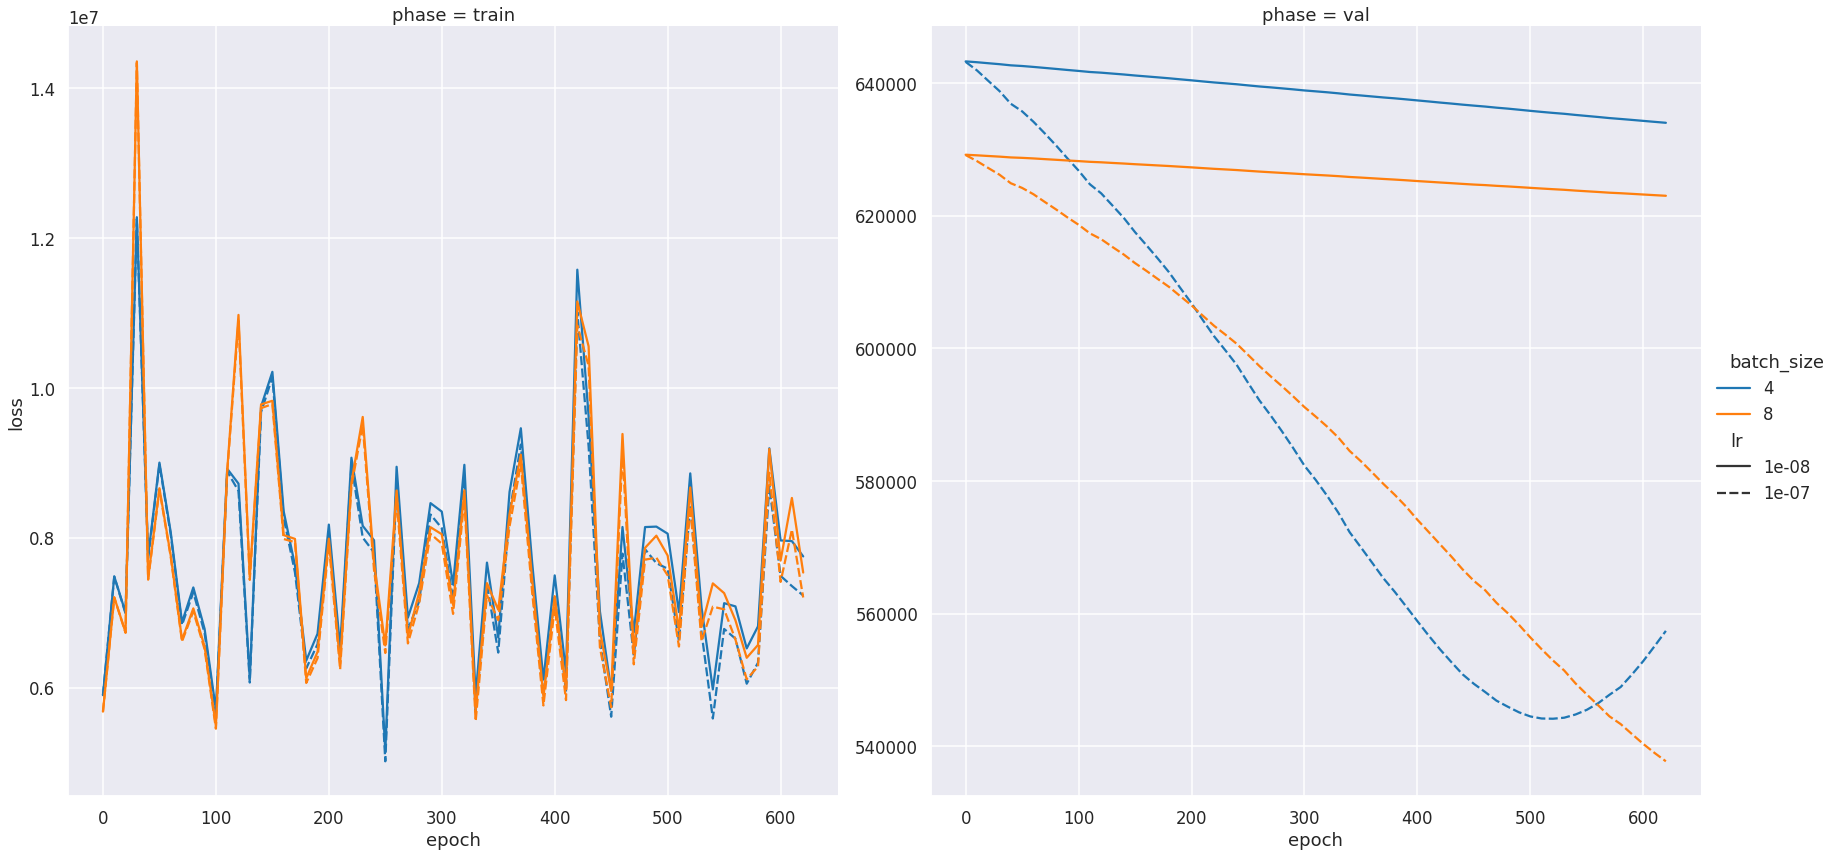

In [8]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    # hue='exp_name',
    # style='seed',
    hue='batch_size',
    style='lr',
    col='phase',
    kind='line',
    height=12,
    facet_kws={
        "sharey":False,
    }
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
# g.set(ylim=(0.0, 0.25))

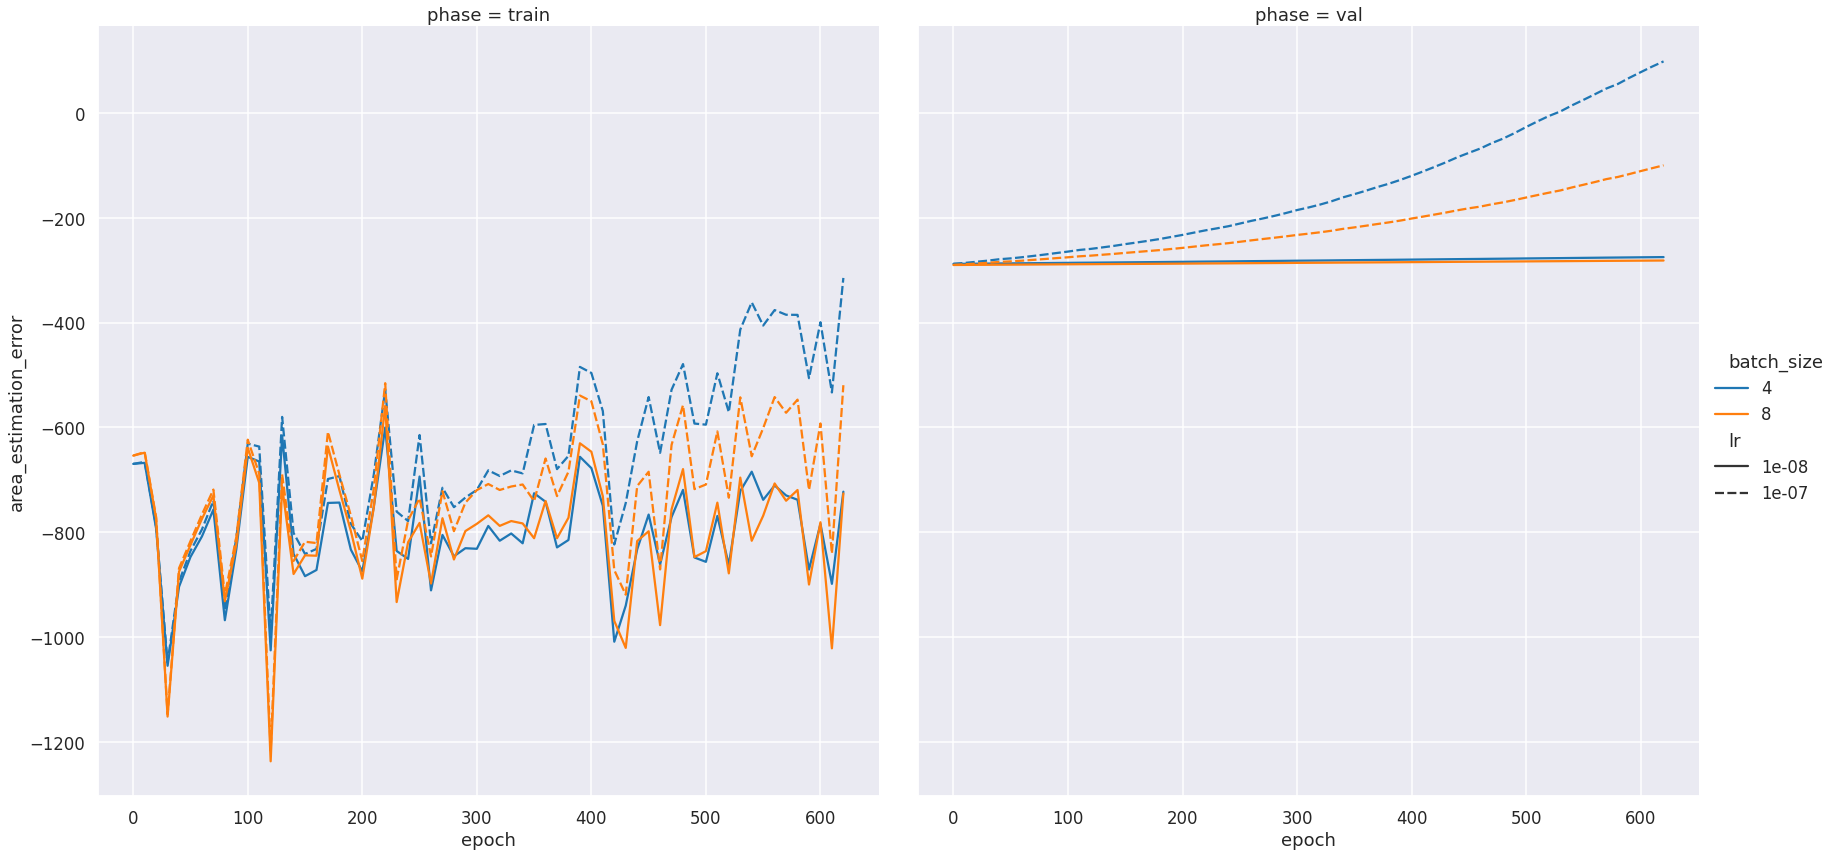

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='area_estimation_error',
    # hue='exp_name',
    # style='seed',
    hue='batch_size',
    style='lr',
    col='phase',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))